# Mixture Models using PyMC

## Simple Gaussian

Generated 5000 samples using parameters [5. 1.]


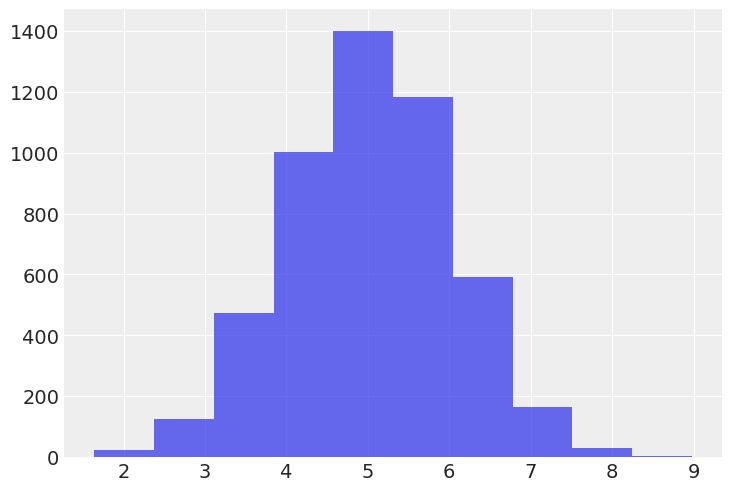

In [83]:
# Create a simple example

import emtk.curves.gaussian as gauss

import numpy as np
import matplotlib.pyplot as plt

curv = gauss.GaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generate_test_samples(pvalues, xrange, 5000)
#curv.generate_background(xrange, 10.0)

measured = curv.data

#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(measured, alpha=0.7)#, density=True)


In [84]:
import arviz as az
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns
az.style.use("arviz-darkgrid")

model = pm.Model()

with model:
    # Priors for unknown model parameters
    mu = pm.Normal("mu", mu=4, sigma=3)
    sigma = pm.HalfNormal("sigma", sigma=2)
        
    like = pm.Normal("like", mu=mu, sigma=sigma, observed=measured)

# MAP model is "maximum a posteriori", i.e. find the peak in the
# posterior likelihood like you do for MLE.
map_estimate=pm.find_MAP(model=model)
map_estimate

# That is equivalent what EMTK is doing, so far so good.

{'mu': array(5.02424317),
 'sigma_log__': array(0.01797906),
 'sigma': array(1.01814166)}

## Gaussian With Background

Generated 2000 samples using parameters [5. 1.]


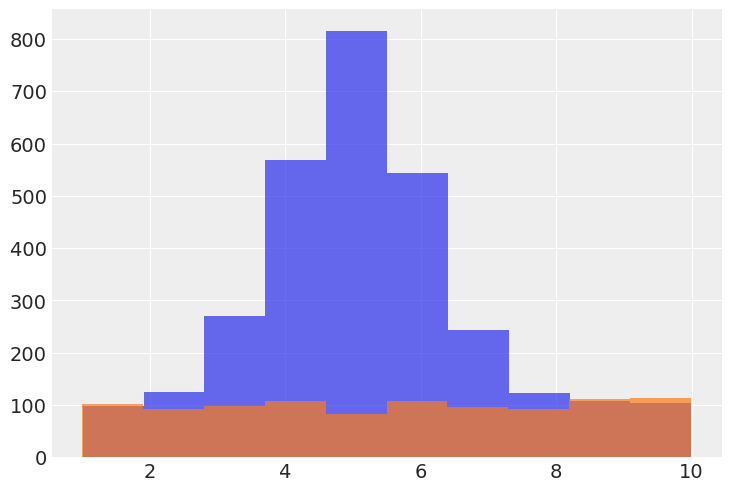

In [85]:
# Create sample measurement and background measurement

import emtk.curves.gaussian as gauss

import numpy as np
import matplotlib.pyplot as plt

curv = gauss.GaussianCurve()

sigma = 1.0
mu = 5.0
pvalues = np.array([mu, sigma])
xrange = np.array([1, 10])
curv.generate_test_samples(pvalues, xrange, 2000)
#curv.generate_background(xrange, 10.0)

sample_bg = np.random.uniform(xrange[0], xrange[1], 1000)
measured_bg = np.random.uniform(xrange[0], xrange[1], 1000)

measured = curv.data
measured = np.append(measured, sample_bg)
np.random.shuffle(measured)


#est = curv.kde(0.02)

fig,ax = plt.subplots()
hh=ax.hist(measured, alpha=0.7)#, density=True)
bb=ax.hist(measured_bg, alpha=0.7)#, density=True)
xgrid = np.arange(2, 8, 0.5)
#xgrid = hh[1]
xgrid = xgrid + 0.5*(xgrid[2]-xgrid[1])
yvals = curv.kde(xgrid)#kdeobject.evaluate(xgrid)


In [86]:
# Now we do the mixture model

import arviz as az
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns
az.style.use("arviz-darkgrid")

model = pm.Model()

with model:
    # mixture model weights
    w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
    # Dirichlet distribution is a multivariate beta distribution,
    # C.F. simple bayesian inference with a beta distribution
    
    # Priors for unknown gaussian model parameters
    mu_par = pm.Normal("mu", mu=4, sigma=3)
    sigma_par = pm.HalfNormal("sigma", sigma=2)
    
    # Components in overall model - simple version because we are 
    # using different component distributions
    components = [
        pm.Uniform.dist(lower=xrange[0], upper=xrange[1]),
        pm.Normal.dist(mu=mu_par, sigma=sigma_par),
    ]
    
    like = pm.Mixture("like", w=w, comp_dists = components, observed=measured)

map_estimate=pm.find_MAP(model=model)
map_estimate
                    

{'weights_simplex__': array([-0.33894137]),
 'mu': array(5.02441957),
 'sigma_log__': array(-0.00662211),
 'weights': array([0.33673402, 0.66326598]),
 'sigma': array(0.99339977)}

**BINGO**

In [87]:
# Now we use MCMC to sample the distributions properly, and obtain a full statistical analysis.

with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'weights'}>,
        <Axes: title={'center': 'weights'}>]], dtype=object)

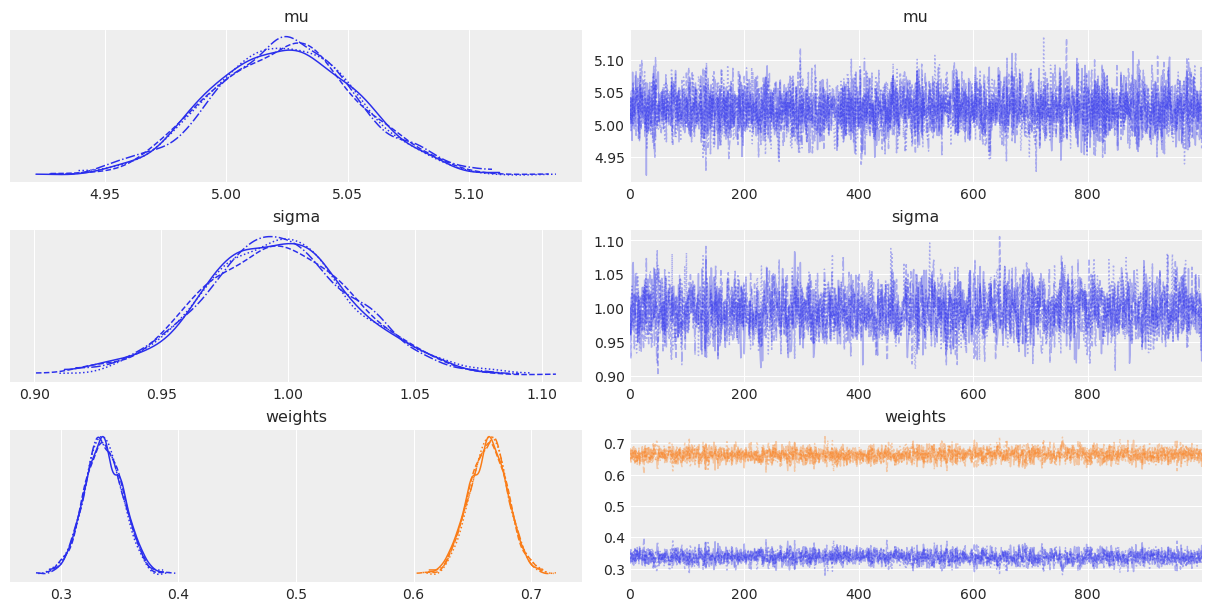

In [88]:
az.plot_trace(idata, var_names=["mu", "sigma", "weights"])

In [89]:
# If we want to do our own statistical analysis on the output, the sample() routine can be called
# with return_inferencedata=False.  This is a much easier object to deal with, to be honest.
with model:
    idata = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [90]:
print(idata.varnames)

['weights_simplex__', 'mu', 'sigma_log__', 'weights', 'sigma']


In [134]:
mu = np.round(np.mean(idata['mu']), decimals = 4)
err_mu = np.round(np.std(idata['mu']), decimals=4)
sigma = np.round(np.mean(idata['sigma']), decimals=4)
err_sigma = np.round(np.std(idata['sigma']), decimals=4)

bg_weight = np.mean(idata['weights'][:,0])
signal_weight = np.mean(idata['weights'][:,1])

print("Loc.  = ", mu, "+/-", err_mu)
print("Sigma = ", sigma, "+/-", err_sigma)
print("Background weight = ", np.round(bg_weight, decimals = 3))
print("Signal weight = ", np.round(signal_weight, decimals = 3))

Loc.  =  5.0249 +/- 0.0287
Sigma =  0.9946 +/- 0.0291
Background weight =  0.337
Signal weight =  0.663


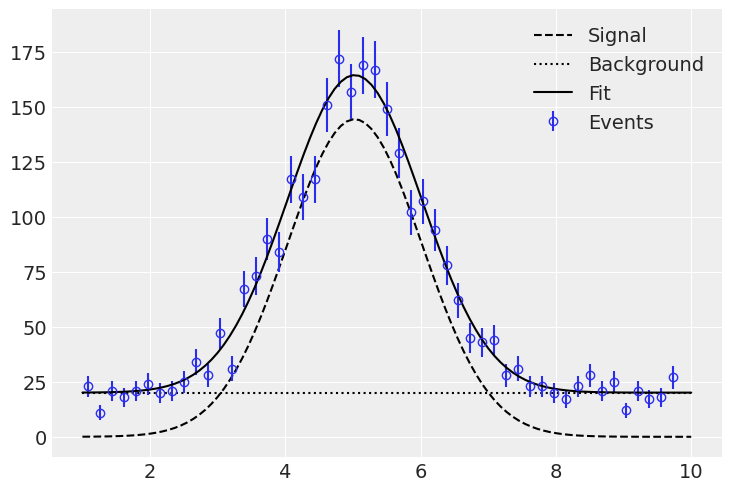

In [126]:

nx = 100.0
nh = 50.0

xi = np.linspace(xrange[0], xrange[1], int(nx))
hbins = np.arange(xrange[0], xrange[1], (xrange[1]-xrange[0])/(nh + 1.0))

# Normalise the signal component
fit_signal = sp.stats.norm.pdf(xi, loc=mu, scale=sigma)
fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

# Normalise the background component
# This next one is brainless but done for the sake of consistency
fit_bg = sp.stats.uniform.pdf(xi, loc=xrange[0], scale=(xrange[1]-xrange[0]))
fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

fit_total = fit_signal + fit_bg

# Get the measured data histogrammed up with error bars
hst = np.histogram(measured, bins=hbins)
rl = np.roll(hbins, -1)
xhist = 0.5*(hbins+rl)
xhist = np.delete(xhist,-1)
yvals = hst[0]
errors= np.sqrt(yvals)

sumhist = np.sum(yvals)

sumfit = np.sum(fit_total)

scale = (nx / nh) * (sumhist / sumfit)

fit_signal = fit_signal * scale
fit_bg = fit_bg * scale
fit_total = fit_total * scale

fig, ax = plt.subplots()
ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
ax.plot(xi, fit_total, color='black', label="Fit")
ax.legend()

# Statistical Comparison to LSE with Noisy Gaussian

In [11]:
import pymc as pm
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from lmfit import Model

xmin = 0.0
xmax = 10.0


def generate_data(npoints, xmin=1.0, xmax=10.0, mu=5.0, sigma=1.0, sn_ratio = 3.0):
    bgfrac = 1.0 / (sn_ratio + 1.0)
    
    nbg = int(np.floor(npoints * bgfrac))
    nsig = npoints - nbg
    
    signal = sp.stats.norm.rvs(size=nsig, loc=mu, scale=sigma)
    background = sp.stats.uniform.rvs(size=nbg, loc=xmin, scale=(xmax+xmin))
    result = np.concatenate((signal, background))
    np.random.shuffle(result)
    
    return result



def bayesian_MAP_fit(spectrum, xmin, xmax, plot=False, verbose=True):

    npts = spectrum.size
    
    model = pm.Model()

    with model:
        # mixture model weights
        w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
        # Dirichlet distribution is a multivariate beta distribution,
        # C.F. simple bayesian inference with a beta distribution
    
        # Priors for unknown gaussian model parameters
        mu_par = pm.Normal("mu", mu=4, sigma=4)
        sigma_par = pm.HalfNormal("sigma", sigma=3)
    
        # Components in overall model - simple version because we are 
        # using different component distributions
        components = [
            pm.Normal.dist(mu=mu_par, sigma=sigma_par),
            pm.Uniform.dist(lower=xmin, upper=xmax),            
        ]
    
        like = pm.Mixture("like", w=w, comp_dists = components, observed=spectrum)

        map_estimate=pm.find_MAP(model=model, progressbar=False, return_raw=True)
        
        # Extracting the sigma and variance is a bit of a faff here
        # PyMC transforms bounded variables so we have to untransform them
        # In this case, it's working with log-sigma
        logsigma_est = map_estimate[0]['sigma_log__']
        sigma_est = np.exp(logsigma_est)
        
        # Since this is basically equivalent to maximum likelihood,
        # the variance of log-sigma is the sqrt of the third element of the 
        # diagonal of the inverse hessian matrix, which scipy conveniently provides
        # for good reason!
        variances = np.sqrt(np.diag(map_estimate[1].hess_inv.todense()))
        logsigma_variance = variances[2]
        logsigma_plus_logvariance = logsigma_est + logsigma_variance
        logsigma_minus_logvariance = logsigma_est - logsigma_variance
        sigmaplus = np.exp(logsigma_plus_logvariance)
        sigmaminus = np.exp(logsigma_minus_logvariance)
        
        err1 = sigmaplus - sigma_est
        err2 = sigma_est - sigmaminus
        err_sigma = 0.5 * (err1 + err2) # statistical resampling finds this is 2x too large
        # so will take the smaller one
        
        err_sigma = np.amin(np.array([err1, err2]))
                                
        mu_est = map_estimate[0]['mu']
        err_mu = variances[1]
        signal_weight = map_estimate[0]['weights'][0]
        bg_weight = map_estimate[0]['weights'][1]

        if verbose:
            print("Data size:", npts)
            print("Loc.  = ", mu_est, "+/-", err_mu)
            print("Sigma = ", sigma_est, "+/-", err_sigma)
            print("Background weight = ", np.round(bg_weight, decimals = 3))
            print("Signal weight = ", np.round(signal_weight, decimals = 3))
            
            
        if plot:
                
            nx = 100.0
            nh = 50.0

            xi = np.linspace(xmin, xmax, int(nx))
            hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

            # Normalise the signal component
            fit_signal = sp.stats.norm.pdf(xi, loc=mu_est, scale=sigma_est)
            fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

            # Normalise the background component
            # This next one is brainless but done for the sake of consistency
            fit_bg = sp.stats.uniform.pdf(xi, loc=xmin, scale=(xmin + xmax))
            fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

            fit_total = fit_signal + fit_bg

            # Get the measured data histogrammed up with error bars
            hst = np.histogram(spectrum, bins=hbins)
            rl = np.roll(hbins, -1)
            xhist = 0.5*(hbins+rl)
            xhist = np.delete(xhist,-1)
            yvals = hst[0]
            errors= np.sqrt(yvals)

            sumhist = np.sum(yvals)

            sumfit = np.sum(fit_total)

            scale = (nx / nh) * (sumhist / sumfit)

            fit_signal = fit_signal * scale
            fit_bg = fit_bg * scale
            fit_total = fit_total * scale

            fig, ax = plt.subplots()
            ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
            ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
            ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
            ax.plot(xi, fit_total, color='black', label="Fit")
            ax.legend()

        return sigma_est, err_sigma




def bayesian_MCMC_fit(spectrum, xmin, xmax, plot=False, verbose=True):

    npts = spectrum.size
    
    model = pm.Model()

    with model:
        # mixture model weights
        w = pm.Dirichlet('weights', a=np.array([1,1])) # 2 weights)
        # Dirichlet distribution is a multivariate beta distribution,
        # C.F. simple bayesian inference with a beta distribution
    
        # Priors for unknown gaussian model parameters
        mu_par = pm.Normal("mu", mu=4, sigma=4)
        sigma_par = pm.HalfNormal("sigma", sigma=3)
    
        # Components in overall model - simple version because we are 
        # using different component distributions
        components = [
            pm.Uniform.dist(lower=xmin, upper=xmax),
            pm.Normal.dist(mu=mu_par, sigma=sigma_par),
        ]
    
        like = pm.Mixture("like", w=w, comp_dists = components, observed=spectrum)

        idata = pm.sample(return_inferencedata=False, progressbar=False)
        
        mu = np.round(np.mean(idata['mu']), decimals = 4)
        err_mu = np.round(np.std(idata['mu']), decimals=4)
        sigma = np.round(np.mean(idata['sigma']), decimals=4)
        err_sigma = np.round(np.std(idata['sigma']), decimals=4)

        bg_weight = np.mean(idata['weights'][:,0])
        signal_weight = np.mean(idata['weights'][:,1])

        if verbose:
            print("Data size:", npts)
            print("Loc.  = ", mu, "+/-", err_mu)
            print("Sigma = ", sigma, "+/-", err_sigma)
            print("Background weight = ", np.round(bg_weight, decimals = 3))
            print("Signal weight = ", np.round(signal_weight, decimals = 3))
            
            
        if plot:
                
            nx = 100.0
            nh = 50.0

            xi = np.linspace(xmin, xmax, int(nx))
            hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

            # Normalise the signal component
            fit_signal = sp.stats.norm.pdf(xi, loc=mu, scale=sigma)
            fit_signal = signal_weight * fit_signal / np.sum(fit_signal)

            # Normalise the background component
            # This next one is brainless but done for the sake of consistency
            fit_bg = sp.stats.uniform.pdf(xi, loc=xmin, scale=(xmin + xmax))
            fit_bg = bg_weight * fit_bg / (np.sum(fit_bg)) # * (xrange[1]-xrange[0]))

            fit_total = fit_signal + fit_bg

            # Get the measured data histogrammed up with error bars
            hst = np.histogram(spectrum, bins=hbins)
            rl = np.roll(hbins, -1)
            xhist = 0.5*(hbins+rl)
            xhist = np.delete(xhist,-1)
            yvals = hst[0]
            errors= np.sqrt(yvals)

            sumhist = np.sum(yvals)

            sumfit = np.sum(fit_total)

            scale = (nx / nh) * (sumhist / sumfit)

            fit_signal = fit_signal * scale
            fit_bg = fit_bg * scale
            fit_total = fit_total * scale

            fig, ax = plt.subplots()
            ax.plot(xi, fit_signal, color='black',linestyle="dashed", label="Signal")
            ax.plot(xi, fit_bg, color='black', linestyle="dotted", label="Background")
            ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
            ax.plot(xi, fit_total, color='black', label="Fit")
            ax.legend()

        return sigma, err_sigma
    
    
    



def gaussian_ls_func(x, amp, mu, sigma, bg):
    first = amp / (sigma * np.sqrt(2.0 * np.pi))
    
    second = np.exp(-0.5 * ((x-mu)/sigma)**2.0)
    
    return first * second + bg

def ls_fit(spectrum, xmin=0.0, xmax=10.0, plot=False, verbose=True):

    mu_guess = np.mean(spectrum)   # actually MLE so should be close
    sigma_guess = 0.5 * np.std(spectrum) # likewise

    gmodel = Model(gaussian_ls_func)
    
    nx = 100.0
    nh = 50.0

    xi = np.linspace(xmin, xmax, int(nx))
    hbins = np.arange(xmin, xmax, (xmax-xmin)/(nh + 1.0))

    hst = np.histogram(spectrum, bins=hbins)
    rl = np.roll(hbins, -1)
    xhist = 0.5*(hbins+rl)
    xhist = np.delete(xhist,-1)
    yvals = hst[0]
    errors= np.sqrt(yvals)
    
    bg_guess = yvals[0]
    amp_guess = np.amax(yvals)
    
    result = gmodel.fit(yvals, x=xhist, amp=amp_guess, mu=mu_guess, sigma=sigma_guess, bg=bg_guess)
    
    if verbose:
        print(result.fit_report())
    
    if plot:
        fig, ax = plt.subplots()
        ax.errorbar(xhist, yvals, errors, fmt='o', mfc='none', label="Events")
        ax.plot(xhist, result.init_fit, '--', color='black', label="LSE initial")
        ax.plot(xhist, result.best_fit, color='black', label="LSE fit")
        ax.legend()
    
    width = result.params["sigma"].value
    variance = result.params["sigma"].stderr
        
    return width, variance    

    

    
    

            
nspectra = 10
sizes = np.round(np.logspace(1, 4, num=nspectra))
print(sizes)

spectra = []
bayesian_widths = []
bayesian_variances = []
least_squares_widths = []
least_squares_variances = []

test_spectrum = generate_data(3000, xmin=xmin, xmax=xmax, sn_ratio=3.0)

for i in range(nspectra):
    spectrum = generate_data(int(sizes[i]), xmin=xmin, xmax=xmax, sn_ratio=3.0)
    spectra.append(spectrum)



[   10.    22.    46.   100.   215.   464.  1000.  2154.  4642. 10000.]


Data size: 3000
Loc.  =  4.9746658519944384 +/- 0.21748230083241643
Sigma =  1.0095712209370025 +/- 0.08158621666940125
Background weight =  0.242
Signal weight =  0.758


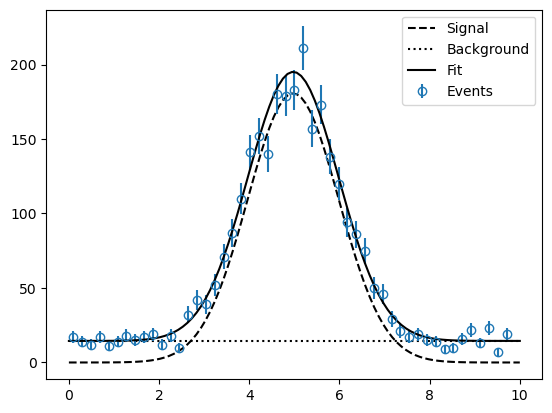

In [70]:
# Before we waste time looping, make sure that the test works correctly for bayesian MAP
obj=bayesian_MAP_fit(test_spectrum, plot=True, xmin=xmin, xmax=xmax)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Data size: 3000
Loc.  =  4.9748 +/- 0.0255
Sigma =  1.0102 +/- 0.0225
Background weight =  0.243
Signal weight =  0.757


(1.0102, 0.0225)

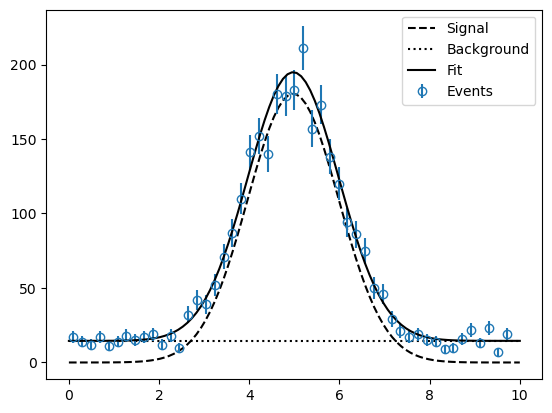

In [71]:
# Before we waste time looping, make sure that the test works correctly for bayesian MCMC
bayesian_MCMC_fit(test_spectrum, plot=True, xmin=xmin, xmax=xmax)

[[Model]]
    Model(gaussian_ls_func)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 50
    # variables        = 4
    chi-square         = 2969.20114
    reduced chi-square = 64.5478508
    Akaike info crit   = 212.201261
    Bayesian info crit = 219.849353
    R-squared          = 0.98353317
[[Variables]]
    amp:    449.911846 +/- 12.5364392 (2.79%) (init = 211)
    mu:     4.97741215 +/- 0.02202000 (0.44%) (init = 4.979772)
    sigma:  1.03034059 +/- 0.02625971 (2.55%) (init = 0.8409462)
    bg:     13.8290840 +/- 1.71054499 (12.37%) (init = 17)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, bg)    = -0.7475
    C(amp, sigma) = +0.7288
    C(sigma, bg)  = -0.5448


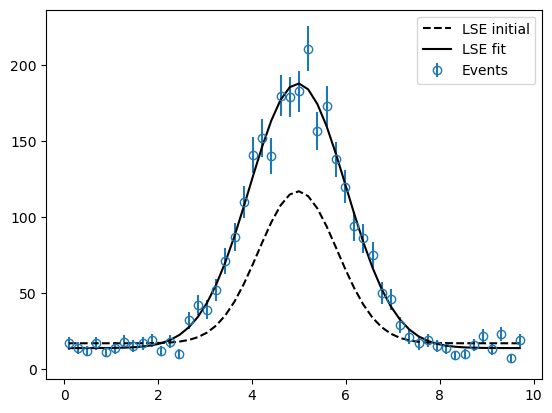

In [72]:
# Before we waste time looping, make sure that the test works correctly for least squares
test_result = ls_fit(test_spectrum, plot=True, verbose=True, xmin=xmin, xmax=xmax)

In [12]:
# Fit all the data runs with least squares regression
least_squares_widths=[]
least_squares_variances=[]

for i in range(nspectra):
    width, variance = ls_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False, verbose=False)
    variance_accum = [width]
    
    for j in range(10):
        resample = generate_data(int(sizes[i]), xmin=xmin, xmax=xmax, sn_ratio=3.0)
        width, variance = ls_fit(resample, xmin=xmin, xmax=xmax, plot=False, verbose=False)
        variance_accum.append(width)
    
    resampled_variance = np.std(np.asarray(variance_accum))
    print("Theoretical variance", variance)
    print("Resampled variance", resampled_variance)
    least_squares_widths.append(width)
    least_squares_variances.append(resampled_variance)

Theoretical variance 1065.8166819446328
Resampled variance 0.5295014100521676
Theoretical variance 0.49421834769648526
Resampled variance 0.5259116987350334
Theoretical variance 0.1950900125055773
Resampled variance 0.1476529654825872
Theoretical variance 0.1799875507457588
Resampled variance 0.17353535293923947
Theoretical variance 0.08605393994073667
Resampled variance 0.09729957038233975
Theoretical variance 0.06460427389772372
Resampled variance 0.06112404113902061
Theoretical variance 0.045742453678182235
Resampled variance 0.04171460717009308
Theoretical variance 0.02526246020657797
Resampled variance 0.032784650941334974
Theoretical variance 0.012974980444196718
Resampled variance 0.01384842142360187
Theoretical variance 0.015181897227614274
Resampled variance 0.011433615241719855


In [14]:
# Fit all the data runs with bayesian MAP
bayesian_MAP_widths = []
bayesian_MAP_variances = []

for i in range(nspectra):
    width, variance = bayesian_MAP_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False)
    
    variance_accum = [width]    
    for j in range(10):
        resample = generate_data(int(sizes[i]), xmin=xmin, xmax=xmax, sn_ratio=3.0)
        width, variance = bayesian_MAP_fit(resample, xmin=xmin, xmax=xmax, plot=False, verbose=False)
        variance_accum.append(width)
    
    resampled_variance = np.std(np.asarray(variance_accum))
    print("Theoretical variance", variance)
    print("Resampled variance", resampled_variance)
    
    bayesian_MAP_widths.append(width)
    bayesian_MAP_variances.append(resampled_variance)

Data size: 10
Loc.  =  5.0906971153546134 +/- 0.7362174339151092
Sigma =  1.2428955159022825 +/- 1.0457786057712262
Background weight =  0.0
Signal weight =  1.0
Theoretical variance 0.12163396794606468
Resampled variance 0.3587125609220512
Data size: 22
Loc.  =  4.596749422642016 +/- 0.23267454634039172
Sigma =  0.8826370033818083 +/- 0.1460912350302811
Background weight =  0.164
Signal weight =  0.836
Theoretical variance 0.18429659073523186
Resampled variance 0.26216830442656297
Data size: 46
Loc.  =  5.01654670116711 +/- 0.17622748720972994
Sigma =  0.828630134437795 +/- 0.13491501258645533
Background weight =  0.178
Signal weight =  0.822
Theoretical variance 0.12933088775623358
Resampled variance 0.11838091366325443
Data size: 100
Loc.  =  5.0586080829745015 +/- 0.15044838904135102
Sigma =  0.9854302228501989 +/- 0.17729292982331368
Background weight =  0.288
Signal weight =  0.712
Theoretical variance 0.15762887885670918
Resampled variance 0.10365108457599584
Data size: 215
Loc.

In [15]:
# Fit all the data runs with bayesian MCMC
bayesian_MCMC_widths = []
bayesian_MCMC_variances = []

for i in range(nspectra):
    width, variance = bayesian_MCMC_fit(spectra[i], xmin=xmin, xmax=xmax, plot=False)
    bayesian_MCMC_widths.append(width)
    bayesian_MCMC_variances.append(variance)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


Data size: 10
Loc.  =  4.9487 +/- 0.9404
Sigma =  1.4179 +/- 0.6361
Background weight =  0.282
Signal weight =  0.718


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Data size: 22
Loc.  =  4.5344 +/- 0.2901
Sigma =  0.9237 +/- 0.2674
Background weight =  0.252
Signal weight =  0.748


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Data size: 46
Loc.  =  5.0201 +/- 0.1672
Sigma =  0.8717 +/- 0.1644
Background weight =  0.201
Signal weight =  0.799


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Data size: 100
Loc.  =  5.0678 +/- 0.1568
Sigma =  1.0502 +/- 0.1729
Background weight =  0.285
Signal weight =  0.715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Data size: 215
Loc.  =  4.9026 +/- 0.0992
Sigma =  1.0983 +/- 0.0865
Background weight =  0.2
Signal weight =  0.8


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Data size: 464
Loc.  =  5.0215 +/- 0.0622
Sigma =  0.9569 +/- 0.057
Background weight =  0.256
Signal weight =  0.744


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Data size: 1000
Loc.  =  4.9993 +/- 0.0402
Sigma =  0.948 +/- 0.0352
Background weight =  0.247
Signal weight =  0.753


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


Data size: 2154
Loc.  =  5.034 +/- 0.0311
Sigma =  1.031 +/- 0.0287
Background weight =  0.25
Signal weight =  0.75


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


Data size: 4642
Loc.  =  5.0075 +/- 0.0198
Sigma =  0.9951 +/- 0.0193
Background weight =  0.253
Signal weight =  0.747


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, mu, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


Data size: 10000
Loc.  =  5.006 +/- 0.0135
Sigma =  0.9906 +/- 0.0124
Background weight =  0.244
Signal weight =  0.756


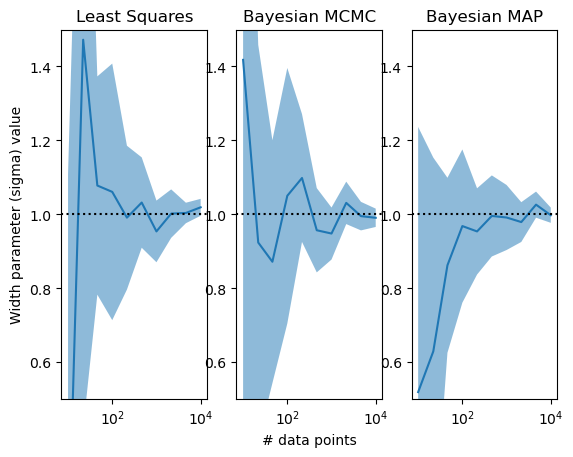

In [16]:
# Compare the fitting methods

fig,ax=plt.subplots(1,3)

# 2 sigma (95%) bands

ls_lower = np.asarray(least_squares_widths) - 2.0 * np.asarray(least_squares_variances)
ls_upper = np.asarray(least_squares_widths) + 2.0 * np.asarray(least_squares_variances)

by_lower = np.asarray(bayesian_MCMC_widths) - 2.0 * np.asarray(bayesian_MCMC_variances)
by_upper = np.asarray(bayesian_MCMC_widths) + 2.0 * np.asarray(bayesian_MCMC_variances)

map_lower = np.asarray(bayesian_MAP_widths) - 2.0 * np.asarray(bayesian_MAP_variances)
map_upper = np.asarray(bayesian_MAP_widths) + 2.0 * np.asarray(bayesian_MAP_variances)

ax[0].plot(sizes, least_squares_widths)
ax[0].fill_between(sizes, y1=ls_lower, y2=ls_upper, alpha=0.5) 
ax[1].plot(sizes, bayesian_MCMC_widths)
ax[1].fill_between(sizes, y1=by_lower, y2=by_upper, alpha = 0.5)
ax[2].plot(sizes, bayesian_MAP_widths)
ax[2].fill_between(sizes, y1=map_lower, y2=map_upper, alpha=0.5)

ax[0].set_xscale('log')
ax[0].set_ylim(0.5, 1.5)
ax[0].set_title('Least Squares')
ax[0].set_ylabel('Width parameter (sigma) value')
ax[0].axhline(y=1.0, color='black', linestyle='dotted')

ax[1].set_xscale('log')
ax[1].set_ylim(0.5, 1.5)
ax[1].set_title('Bayesian MCMC')
ax[1].axhline(y=1.0, color='black', linestyle='dotted')
ax[1].set_xlabel('# data points')

ax[2].set_title('Bayesian MAP')
ax[2].set_xscale('log')
ax[2].set_ylim(0.5, 1.5)
ax[2].axhline(y=1.0, color='black', linestyle='dotted')